<h1> <center> Information-based Learning Using Decision Tree

<h2> Introduction </h2>

The goal of this project is to implement the Iterative Dichotomiser 3 (ID3) algorithm which is used to create decision trees. The decision trees are used for classification. A decision tree is a flowchart-like structure which uses the approach of posing series of questions about the characteristics of data. And pose follow up questions until a conclusion about the class label of the record is reached.

In [1]:
#Importing libraries
import pandas as pd
from collections import Counter
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import random

<h2> A. Fishing Data
    
<h3> 1. Load Data </h3>

In [2]:
# read file
file1 = pd.read_csv('data/fishing.data', names = ["Wind", "Water", "Air", "Forecast", "class"])
data_1 = pd.DataFrame(file1[8:]).reset_index().drop('index', 1)

# splitting into training and test set
train_df = data_1.sample(frac=0.7,random_state=100) #random state is a seed value
test_df = data_1.drop(train_df.index).reset_index().drop('index', 1)

train_df

,Wind,Water,Air,Forecast,class
11,Weak,Moderate,Warm,Sunny,Yes
12,Strong,Warm,Cool,Sunny,Yes
5,Weak,Cold,Cool,Rainy,No
1,Weak,Warm,Warm,Sunny,No
9,Strong,Moderate,Cool,Rainy,No
4,Strong,Cold,Cool,Rainy,No
6,Weak,Cold,Cool,Sunny,No
2,Strong,Warm,Warm,Cloudy,Yes
0,Strong,Warm,Warm,Sunny,Yes
10,Weak,Moderate,Cool,Sunny,Yes


<h3> 2. Functions </h3>

ID3 algorithm uses the concept of information gain, which is defined in terms of entropy. Inorder to decide the class for any new instance, first the algorithm needs to divide the dominant attribute into two groups to construct a tree. For this, algorithm calcutes the entropy and information gains for each of the attribute and the most dominant attribute is put on the tree as decision node. This procedure is repeated untill reaching the decision for that branch. 

A dataset having different class type with each class having same probability of occuring, the entropy of the dataset will be high which means that there is no certainity in prediciting class of random instances. If there is high entropy, the uncertainity will be high and less information will be gained and viceversa. Below are the functions for calculating entropy for the attributes.

In [3]:
#Function for calculating Entropy:
def entropy(vals):
    return sum([-val*math.log(val, 2) for val in vals])

def entropy_of_table(series):  
    count_class = Counter(x for x in series)   # Calculates numbers of each class 
    total_obs = len(series) # total number of rows
    #print("\n Number of observations for the Current Class: {0}".format(total_obs))
    vals = [x / total_obs for x in count_class.values()]  # x means number of each class
    return entropy(vals) 
    

Information gain is calculated for each attribute in the dataset in the following steps:

- The total number of instances in the data set are calculated
- Partition each attribute values into subsets and calculate the entropy score of this subset.
- Calculate the information gain for each attribute: Information gain = old entropy for this attribute  – new entropy for this attribute.

In [4]:
# Function for calculating Information Gain:
def information_gain(train_df, attr_name, target_attribute_name):
    print("\n Information Gain Calculation of ", attr_name)
    
    train_df_split = train_df.groupby(attr_name) # Grouped based on attribute values:
   
    nobs = len(train_df.index) #number of observations in the dataset
   
    # Calculate the entropy for each attribute value:
    train_df_agg_ent = train_df_split.agg({target_attribute_name : [entropy_of_table, lambda x: len(x)/nobs] })[target_attribute_name]
    train_df_agg_ent.columns = ['Entropy', 'PropObservations']
    print(train_df_agg_ent['Entropy']) # gives entropy value for each attribute
    
    # Calculate Information Gain:
    new_entropy = sum(train_df_agg_ent['Entropy'] * train_df_agg_ent['PropObservations'] )
    old_entropy = entropy_of_table(train_df[target_attribute_name])
    
    return old_entropy - new_entropy
 
#print('\nInformation Gain for *** is :'+ str( information_gain(train_df, attr, 'class')),"\n\n")
    
print('\nInformation Gain for Wind is :'+ str( information_gain(train_df, 'Wind', 'class')),"\n\n")
print('\nInformation Gain for Water is:' + str( information_gain(train_df, 'Water', 'class')),"\n\n")
print('\nInformation Gain for Air is:' + str( information_gain(train_df, 'Air', 'class')),"\n\n")
print('\nInformation Gain for Forecast is:' + str( information_gain(train_df, 'Forecast','class')),"\n\n")




 Information Gain Calculation of  Wind
Wind
Strong    0.970951
Weak      0.970951
Name: Entropy, dtype: float64

Information Gain for Wind is :0.02904940554533142 



 Information Gain Calculation of  Water
Water
Cold        0.000000
Moderate    0.918296
Warm        0.811278
Name: Entropy, dtype: float64

Information Gain for Water is:0.4 



 Information Gain Calculation of  Air
Air
Cool    0.918296
Warm    0.811278
Name: Entropy, dtype: float64

Information Gain for Air is:0.12451124978365313 



 Information Gain Calculation of  Forecast
Forecast
Cloudy    0.000000
Rainy     0.000000
Sunny     0.918296
Name: Entropy, dtype: float64

Information Gain for Forecast is:0.44902249956730633 




<h3> 3. Train Data </h3> 

ID3 Implementation

- If all instances in the dataset 'S' are of the same class, the function returns a leaf with that class label.
- If there are no more attributes to test then the function returns a leaf with the most common class label.
- Otherwise the function will choose the attribute that maximizes the Information Gain of S
- That attribute is chosen to be the decision for the current node and a branch is added from the that node for each possible value of that attribute.
- For each branch, the instances are “sorted” down the branches based on their value of that attribute.
- Then, ID3 is called recursively on the set of instances in each branch.

In [5]:
# Function for ID3 algorithm: 
def id3(train_df, target_attribute_name, attribute_names):
    
    count_class = Counter(x for x in train_df[target_attribute_name])# number of each classes 
    
    # Check if all observations have the same class:
    if len(count_class) == 1:
        return next(iter(count_class))  #returns the leaf of that class label
    
    # Check if the datset is empty or check if there are no more attributes and return most common class if yes:
    elif train_df.empty or (not attribute_names):
        return max(count_class)  # Return most common class
    
    else:
        # Set default value for next recursive call of this function:
        default_class = max(count_class.keys()) 
        
        # Calculate the Information Gain of the attributes:
        gainz = [information_gain(train_df, attr, target_attribute_name) for attr in attribute_names] 
        
        # Determine best attribute to split on based on the value of Information Gain:
        index_of_max = gainz.index(max(gainz)) # getting index of maximum value of information gain
        best_attr = attribute_names[index_of_max] # gettin the best attribute 
        
        # Create an empty tree/nested dictionary to be populated: 
        tree = {best_attr:{}} # setting up the tree with best attribute as the node 
        
        remaining_attribute_names = [i for i in attribute_names if i != best_attr] # list of attributes (without the best attribute)
        #print('---------------------------------------------------------------------')
        #for i in remaining_attribute_names:
            #value = str(information_gain(train_df,i, target_attribute_name))
            #print('Information Gain for {0} is:{1}'.format(str(i),str(value)))
        #print('---------------------------------------------------------------------')
        
        
        # Split the dataset based on the attribute values of the best attribute and recursively call this algorithm on each splits:
        for attr_val, data_subset in train_df.groupby(best_attr):
            subtree = id3(data_subset,
                        target_attribute_name,
                        remaining_attribute_names)
                        
            tree[best_attr][attr_val] = subtree # populates the empty tree with subtrees
        return tree



In [6]:
# Initial entropy of the 'class' attribute for given dataset.
total_entropy = entropy_of_table(train_df['class'])

print("\nTotal Entropy for the given dataset: ",total_entropy,'\n\n')

attribute_names = list(train_df.columns)
print("List of Attributes:", attribute_names,'\n') 
attribute_names.remove('class') # Remove the class attribute 
print("Predicting Attributes:", attribute_names, '\n\n')


# Call ID3 recursive Algorithm:
from pprint import pprint # pprint or pretty print gives a better representation of the Decision Tree
tree = id3(train_df,'class',attribute_names)
print("\n\n Decision Tree :\n")
pprint(tree)
attribute = next(iter(tree))
print("Best Attribute :\n",attribute)
print("Tree Keys:\n",tree[attribute].keys())


Total Entropy for the given dataset:  1.0 


List of Attributes: ['Wind', 'Water', 'Air', 'Forecast', 'class'] 

Predicting Attributes: ['Wind', 'Water', 'Air', 'Forecast'] 



 Information Gain Calculation of  Wind
Wind
Strong    0.970951
Weak      0.970951
Name: Entropy, dtype: float64

 Information Gain Calculation of  Water
Water
Cold        0.000000
Moderate    0.918296
Warm        0.811278
Name: Entropy, dtype: float64

 Information Gain Calculation of  Air
Air
Cool    0.918296
Warm    0.811278
Name: Entropy, dtype: float64

 Information Gain Calculation of  Forecast
Forecast
Cloudy    0.000000
Rainy     0.000000
Sunny     0.918296
Name: Entropy, dtype: float64

 Information Gain Calculation of  Wind
Wind
Strong    0.0
Weak      1.0
Name: Entropy, dtype: float64

 Information Gain Calculation of  Water
Water
Cold        0.000000
Moderate    0.000000
Warm        0.918296
Name: Entropy, dtype: float64

 Information Gain Calculation of  Air
Air
Cool    0.918296
Warm    0.918296
Nam

<h3> 4. Tree Visualization </h3>

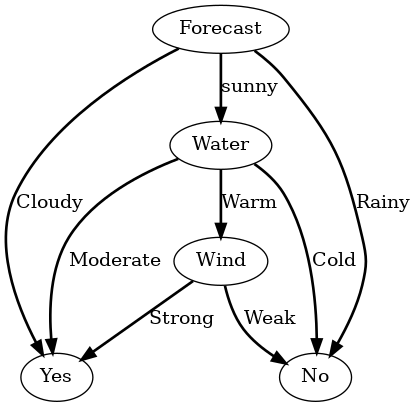

In [7]:
from anytree import NodeMixin, RenderTree
from anytree import AnyNode, RenderTree
from anytree.exporter import DotExporter
from IPython.display import Image

class WNode(NodeMixin):
    def __init__(self, foo, parent=None, weight=None):
        super(WNode, self).__init__()
        self.foo = foo
        self.parent = parent
        self.weight = weight if parent is not None else None
    def _post_detach(self, parent):
        self.weight = None
        
root = WNode("Forecast")
leaf1 = WNode("Yes", parent=root, weight='Cloudy')
leaf2 = WNode("No", parent=root, weight='Rainy')
v1 = WNode("Water", parent=root, weight='sunny')
v2 = WNode("Wind", parent=v1, weight='Warm')
leaf3 = WNode("Yes", parent=v2, weight='Strong')
leaf4 = WNode("No", parent=v2, weight='Weak')
leaf5 = WNode("Yes", parent=v1, weight='Moderate')
leaf6 = WNode("No", parent=v1, weight='Cold')
DotExporter(root,
            nodenamefunc=lambda node: node.foo,
        edgeattrfunc=lambda parent, child: "style=bold,label=%s" % (child.weight or 0)).to_picture("fishing.png")

Image("fishing.png")

<h3> 5. Prediction </h3>

In [8]:
def classify(data):
    Wind = data[0]
    Water = data[1]
    Air = data[2]
    Forecast = data[3]
    
    if Forecast == 'Sunny':
        if Water == 'Warm':
            if Wind == 'Strong':
                return 'Yes'
            else:
                return 'No'
        elif Water == 'Moderate':
                return 'Yes'
        else:
            return 'No'
    elif Forecast == 'Rainy':
        return 'No'
    else:
        return 'Yes'

In [9]:
test_df['Predicted']=""
hit_count = 0
for index,row in test_df.iterrows():
    arg = test_df.iloc[index].tolist()
    test_df.iloc[index]['Predicted'] = classify(arg)
    if test_df.iloc[index]['Predicted'] == test_df.iloc[index]['class']:
        hit_count+=1
test_df


,Wind,Water,Air,Forecast,class,Predicted
0,Strong,Moderate,Warm,Rainy,Yes,No
1,Strong,Moderate,Warm,Sunny,Yes,Yes
2,Strong,Cold,Cool,Sunny,Yes,No
3,Weak,Moderate,Warm,Rainy,No,No


<h3> 6. Evaulation of model </h3>

The model evaluation metrics such as accuracy, precision, recall as well as confusion matrix werethen used to evaluate model's performance.

In [10]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score, plot_confusion_matrix

confusion = confusion_matrix(test_df['class'], test_df.Predicted)
score = f1_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average='weighted')
prec = precision_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average= 'weighted')
recall = recall_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average= 'weighted')

print('Accuracy of the model is:', score)
print('Precision is:', prec)
print('Recall is:',recall)

Accuracy of the model is: 0.5
Precision is: 0.8333333333333334
Recall is: 0.5


/mnt/c/Users/shaky/Documents/linux/envs/decisiontree/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['No', 'Yes']) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

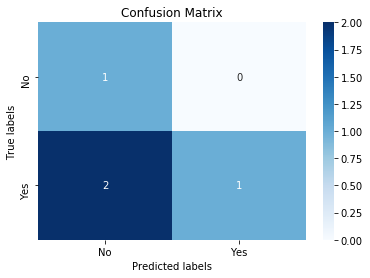

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, cmap = 'Blues') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(set(test_df['class']))); ax.yaxis.set_ticklabels(list(set(test_df['class'])))

The above figure shows the confusion matrix for the test data. Since this is small dataset, the train and test set contains only few records (70% train , 30% test). The following values were obtained from the confusion matrix:

- TP = 1 (cases for which fishing is 'No' were actually predicted as 'No') 
- FP = 2 (cases for which fishing is 'Yes' but were incorrectly predicted 'No') 
- FN = 0 (cases for which fishing is 'No' were incorrectly predicted as 'Yes') 
- TN = 1 (cases for which  fishing is 'Yes' were actually predicted as 'Yes')

Accuracy = 50% Precision = 83% Recall = 50%

Using this model, for each 100 instances it classified, 50 were correctly classified. Around 50% of the 'Yes' were incorrectly predicted 'No'. Similarly, around 17% of 'No' were  were incorrectly predicted 'Yes'.

<h2> B. Contact-lenses Data

<h3> 1. Load Data </h3>

In [12]:
# read file
file2 = pd.read_csv('data/contact-lenses.data', names = ["Age", "Prescription", "Astigmatism", "Tear-rate", "class"])
data_2 = pd.DataFrame(file2[8:]).reset_index().drop('index', 1)

# splitting into training and test set
train_df = data_2.sample(frac=0.8,random_state=1000) #random state is a seed value
test_df = data_2.drop(train_df.index).reset_index().drop('index', 1)
train_df


,Age,Prescription,Astigmatism,Tear-rate,class
5,young,hypermetrope,no,normal,soft
22,presbyopic,hypermetrope,yes,reduced,none
3,young,myope,yes,normal,hard
6,young,hypermetrope,yes,reduced,none
23,presbyopic,hypermetrope,yes,normal,none
20,presbyopic,hypermetrope,no,reduced,none
2,young,myope,yes,reduced,none
17,presbyopic,myope,no,normal,none
18,presbyopic,myope,yes,reduced,none
16,presbyopic,myope,no,reduced,none


<h3> 2. Train Data </h3>

In [13]:
#print("\n Given dataset:\n\n", train_df)

# Initial entropy of the 'class' attribute for given dataset.
total_entropy = entropy_of_table(train_df['class'])

print("\nTotal Entropy for the given dataset: ",total_entropy,'\n\n')

attribute_names = list(train_df.columns)
print("List of Attributes:", attribute_names,'\n') 
attribute_names.remove('class') # Remove the class attribute 
print("Predicting Attributes:", attribute_names, '\n\n')


# Call ID3 recursive Algorithm:
from pprint import pprint # pprint or pretty print gives a better representation of the Decision Tree
tree = id3(train_df,'class',attribute_names)
print("\n\n Decision Tree :\n")
pprint(tree)
attribute = next(iter(tree))
print("Best Attribute :\n",attribute)


Total Entropy for the given dataset:  1.086987702339905 


List of Attributes: ['Age', 'Prescription', 'Astigmatism', 'Tear-rate', 'class'] 

Predicting Attributes: ['Age', 'Prescription', 'Astigmatism', 'Tear-rate'] 



 Information Gain Calculation of  Age
Age
pre-presbyopic    1.298795
presbyopic        0.000000
young             1.370951
Name: Entropy, dtype: float64

 Information Gain Calculation of  Prescription
Prescription
hypermetrope    0.721928
myope           1.224394
Name: Entropy, dtype: float64

 Information Gain Calculation of  Astigmatism
Astigmatism
no     0.918296
yes    0.721928
Name: Entropy, dtype: float64

 Information Gain Calculation of  Tear-rate
Tear-rate
normal     1.561278
reduced    0.000000
Name: Entropy, dtype: float64

 Information Gain Calculation of  Age
Age
pre-presbyopic    1.5
presbyopic        0.0
young             1.0
Name: Entropy, dtype: float64

 Information Gain Calculation of  Prescription
Prescription
hypermetrope    1.0
myope           1.

<h3> 3. Tree Visualization </h3>

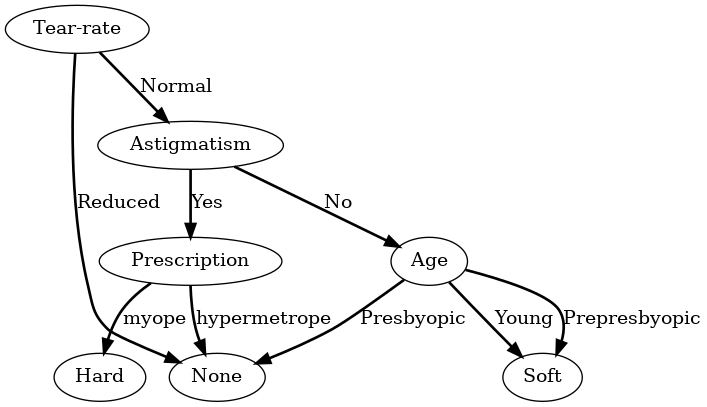

In [14]:
root = WNode("Tear-rate")
leaf1 = WNode("None", parent=root, weight='Reduced')
v1 = WNode("Astigmatism", parent=root, weight='Normal')
v2 = WNode("Age", parent=v1, weight='No')
leaf2 = WNode("Soft", parent=v2, weight='Prepresbyopic')
leaf3 = WNode("Soft", parent=v2, weight='Young')
leaf3 = WNode("None", parent=v2, weight='Presbyopic')

v3 = WNode("Prescription", parent=v1, weight='Yes')
leaf5 = WNode("None", parent=v3, weight='hypermetrope')
leaf6 = WNode("Hard", parent=v3, weight='myope')

DotExporter(root,
            nodenamefunc=lambda node: node.foo,
        edgeattrfunc=lambda parent, child: "style=bold,label=%s" % (child.weight or 0)).to_picture("contact-lenses.png")

Image("contact-lenses.png")

<h3> 4. Prediction </h3>

In [15]:
def classify(data):
    Age = data[0]
    Prescription = data[1]
    Astigmatism = data[2]
    Tear_rate = data[3]
    
    
    if Tear_rate == 'normal':
        if Astigmatism == 'yes':
            if Prescription == 'hypermetrope':
                return 'none'
            else:
                return 'hard'
                
        else:
            if Age == 'pre-presbyopic':
                return 'soft'
            elif Age == 'young':
                return 'soft'
        
            else:
                return 'none'         
    else:
        return 'none'

In [16]:
test_df

,Age,Prescription,Astigmatism,Tear-rate,class
0,young,myope,no,reduced,none
1,young,myope,no,normal,soft
2,young,hypermetrope,yes,normal,hard
3,presbyopic,myope,yes,normal,hard
4,presbyopic,hypermetrope,no,normal,soft


In [17]:
test_df['Predicted']=""
hit_count = 0
for index,row in test_df.iterrows():
    arg = test_df.iloc[index].tolist()
    test_df.iloc[index]['Predicted'] = classify(arg)
    if test_df.iloc[index]['Predicted'] == test_df.iloc[index]['class']:
        hit_count+=1
test_df

  

,Age,Prescription,Astigmatism,Tear-rate,class,Predicted
0,young,myope,no,reduced,none,none
1,young,myope,no,normal,soft,soft
2,young,hypermetrope,yes,normal,hard,none
3,presbyopic,myope,yes,normal,hard,hard
4,presbyopic,hypermetrope,no,normal,soft,none


<h3> 5. Evaluation </h3>

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score, plot_confusion_matrix

confusion = confusion_matrix(test_df['class'], test_df.Predicted)
score = f1_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average='weighted')
prec = precision_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average= 'weighted')
recall = recall_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average= 'weighted')

print('Accuracy of the model is:', score)
print('Precision is:', prec)
print('Recall is:',recall)

Accuracy of the model is: 0.6333333333333333
Precision is: 0.8666666666666668
Recall is: 0.6


/mnt/c/Users/shaky/Documents/linux/envs/decisiontree/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['none', 'soft', 'hard']) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


[Text(0, 0.5, 'none'), Text(0, 1.5, 'soft'), Text(0, 2.5, 'hard')]

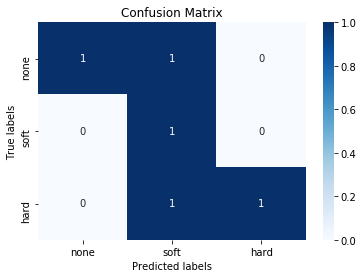

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, cmap = 'Blues') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(set(test_df['class']))); ax.yaxis.set_ticklabels(list(set(test_df['class'])))

The above figure shows the confusion matrix for the test data. Since this is small dataset, the train and test set contains only few records (80% train , 20% test). The following values were obtained from the confusion matrix:

- TP-None = 1 (cases for which contact lenses is 'None' were actually predicted as 'None') 
- TP-Hard = 1 (cases for which contact lenses is 'Hard' were actually predicted as 'Hard') 
- TP-Soft = 1 (cases for which contact lenses is 'Soft' were actually predicted as 'Soft') 
- None-Hard = 1 (cases for which contact lenses is 'None' were incorreclty predicted as 'Hard') 
- None-Soft = 1 (cases for which contact lenses is 'None' were incorreclty predicted as 'Soft')
- Hard-None = 0 (cases for which contact lenses is 'Hard' were incorreclty predicted as 'None') 
- Hard-Soft = 0 (cases for which contact lenses is 'Hard' were incorreclty predicted as 'Soft')
- Soft-None = 0 (cases for which contact lenses is 'Hard' were incorreclty predicted as 'None') 
- Soft-Hard = 1 (cases for which contact lenses is 'Soft' were incorreclty predicted as 'Hard')

Accuracy = 63% Precision = 87% Recall = 60%

Using this model, for each 100 instances it classified, 63 were correctly classified.

<h2> C. Iris Data </h2>


For the iris dataset, we took reference from the Coding a Decision Tree from Scratch in Python p.1- p.7, Sebastian Mantey. [Link: https://www.youtube.com/watch?v=ZdKnZ1xKrRA&list=PLPOTBrypY74xS3WD0G_uzqPjCQfU6IRK-&index=7]

<h3> 1. Load Data </h3>

In [20]:
file3 = pd.read_csv('data/iris.data', names = ["sepalLength","sepalWidth","petalLength","petalWidth", "class"])
data3 = pd.DataFrame(file3[8:]).reset_index()
data3 = data3.drop('index', 1)
data3

# splitting into training and test set
train_df = data3.sample(frac=0.7,random_state=100) #random state is a seed value
test_df = data3.drop(train_df.index).reset_index().drop('index', 1)

test_df['sepalLength'] =test_df['sepalLength'].astype(float)
test_df['sepalWidth'] = test_df['sepalWidth'].astype(float)
test_df['petalLength'] = test_df['petalLength'].astype(float)
test_df['petalWidth'] = test_df['petalWidth'].astype(float)

<h3> 2. Functions </h3>

In [21]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    return data_below, data_above

#Function for calculating Entropy:
def entropy(data):
    label = data[:, -1]
    _, counts = np.unique(label, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

def calculate_overall_entropy(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * entropy(data_below) 
                      + p_data_above * entropy(data_above))
    
    return overall_entropy

def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

<h3> 3. Train Data </h3>

In [22]:
def decision_tree(df,counter=0):
    if counter == 0:
        global attribute_names
        attribute_names = df.columns
        data = df.values
    else:
        data = df           
    
    label = data[:, -1]

    unique_label, unique_label_count = np.unique(label, return_counts=True)
    
    if len(unique_label) == 1:
        index = unique_label_count.argmax()
        classify = unique_label[index]
        return classify 
    
    else: 
        counter += 1
        split_xvalues = {}
        for c in range(data.shape[1]-1):
            cols = data[:, c]
            unique_values = list(set(cols))
            split_xvalues[c] = unique_values
        
        split_column, split_value = determine_best_split(data, split_xvalues)
        data_lower, data_upper = split_data(data, split_column, split_value)

        #check for empty data
        if len(data_lower) == 0 or len(data_upper) == 0:
            classify = classify_data(data)
            return classify    
        
        # determine question

        feature_names = attribute_names[split_column]
        question = "{} <= {}".format(feature_names, split_value)
                  
        #sub-tree
        sub_tree = {question: []}
        
        #(recursion)
        yes_answer = decision_tree(data_lower,counter)
        no_answer = decision_tree(data_upper,counter)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

<h3> 4. Prediction </h4>

In [24]:
def classify1(data):
    sepalLength = data[0]
    sepalWidth = data[1]
    petalLength = data[2]
    petalWidth = data[3]
    
    if petalWidth <= 0.6:
        return 'Iris-setosa'
    else:
        if petalWidth <= 1.7:
            if petalLength <= 4.9:
                return 'Iris-versicolor'
            else:
                if petalWidth <= 1.5:
                    if petalLength <= 1.6:
                        return 'Iris-versicolor'
                    else:
                        return 'Iris-virginica'
                else:
                    if petalLength <= 5.1:
                        return 'Iris-versicolor'
                    else:
                        return 'Iris-virginica'
        else:
            if petalLength <= 4.8:
                if sepalWidth <= 3.0:
                    return 'Iris-virginica'
                else:
                    return 'Iris-versicolor'
            else:
                return 'Iris-virginica'

In [25]:
hit_count = 0
def dd(test_df):
    l = []
    for index,row in test_df.iterrows():
        arg = test_df.iloc[index].tolist()
        l.append(classify1(arg))
    return(l)

test_df['Predicted'] = dd(test_df)
test_df.head(5)


,sepalLength,sepalWidth,petalLength,petalWidth,class,Predicted
0,4.7,3.2,1.3,0.2,Iris-setosa,Iris-setosa
1,5.0,3.6,1.4,0.2,Iris-setosa,Iris-setosa
2,5.0,3.4,1.5,0.2,Iris-setosa,Iris-setosa
3,4.4,2.9,1.4,0.2,Iris-setosa,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa,Iris-setosa


<h3> 5. Evaluation </h3>

In [26]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score, plot_confusion_matrix

confusion = confusion_matrix(test_df['class'], test_df.Predicted)
score = f1_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average='weighted')
prec = precision_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average= 'weighted')
recall = recall_score(test_df['class'],test_df.Predicted,pos_label=list(set(test_df['class'])),average= 'weighted')

print('Accuracy of the model is:', score)
print('Precision is:', prec)
print('Recall is:',recall)

Accuracy of the model is: 1.0
Precision is: 1.0
Recall is: 1.0


/mnt/c/Users/shaky/Documents/linux/envs/decisiontree/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to ['Iris-virginica', 'Iris-versicolor', 'Iris-setosa']) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


[Text(0, 0.5, 'Iris-virginica'),
 Text(0, 1.5, 'Iris-versicolor'),
 Text(0, 2.5, 'Iris-setosa')]

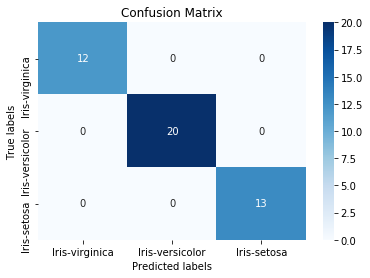

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, cmap = 'Blues') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(set(test_df['class']))); ax.yaxis.set_ticklabels(list(set(test_df['class'])))

Accuracy = 100% Precision = 100% Recall = 100%

Using this model, for each 100 instances it classified, 100 were correctly classified.

<h2> Conclusion </h2>

Nested dictionary has been used in this project to obtain the decision tree which has been visualized using 'anyTree' library. If-Then rule has been used for prediction. Since the datasets are quite small, the accuracies obtained are not that high. Techchniques such as pruning, boosting and bagging could be used for the further improving the performance of the model.